**Import modules**

In [1]:
import os
import numpy as np
import tensorflow as tf

**Load CIFAR-10**

In [2]:
CIFAR_DIR = '/home/commaai-03/Data/dataset/cifar-10-python'

def unpickle(file):
    import pickle
    with open(file, 'rb') as f:
        data = pickle.load(f, encoding='bytes')
    return data

In [3]:
filenames = [os.path.join(CIFAR_DIR, file)
             for file in os.listdir(CIFAR_DIR)
             if '.html' not in file]
filenames.sort()
meta_file = filenames[0]
train_files = filenames[1:-1]
test_file = [filenames[-1]]

**Test Data Handle**

In [4]:
_test_data = unpickle(test_file[0])
for k, v in _test_data.items():
    print(k)

b'batch_label'
b'labels'
b'data'
b'filenames'


(32, 32, 3)

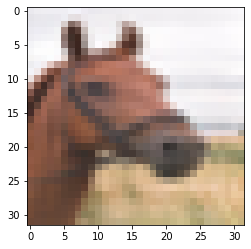

In [5]:
img_size = 32
img_arr = _test_data[b'data'][99]
# 32 * 32 * 3 (R,G,B)
img_arr_reshaped = img_arr.reshape((3, img_size, img_size))
img = img_arr_reshaped.transpose(1, 2, 0)
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

%matplotlib inline
imshow(img)
img.shape

In [6]:
class CifarDate:
    
    def __init__(self, filenames, need_shuffle):
        all_data = []
        all_label = []
        if not isinstance(filenames, (list, tuple)):
            raise TypeError('%s are not iterable.' % filenames)
        for filename in filenames:
            data, labels = self.load_data(filename)
            all_data.append(data)
            all_label.append(labels)
            #all_data.append(data)
            #all_label.append(labels)
        self._data = np.vstack(all_data) / 127.5 - 1
        self._label = np.hstack(all_label)
        print('[CIFAR-10]: Data shape-> %s' % str(self._data.shape))
        print('[CIFAR-10]: Label shape-> %s' % str(self._label.shape))
        
        self.num_examples = self._data.shape[0]
        self._need_shuffle = need_shuffle
        self._indicator = 0
        if self._need_shuffle:
            self._shuffle_data()
        

    def load_data(self, filename):
        import pickle
        with open(filename, mode='rb') as f:
            data = pickle.load(f, encoding='bytes')
        return data[b'data'], data[b'labels']
        
    def _shuffle_data(self):
        index = np.random.permutation(self.num_examples)
        self._data = self._data[index]
        self._label = self._label[index]
        
    def next_batch(self, batch_size):
        end_indicator = self._indicator + batch_size
        if end_indicator > self.num_examples:
            rest_num_examples = self.num_examples - self._indicator
            data_rest_part = self._data[self._indicator: self.num_examples]
            label_rest_part = self._label[self._indicator: self.num_examples]
            
            if self._need_shuffle:
                self._shuffle_data()
            # For new loop, self._indicator + batch_size = self.num_examples
            self._indicator = batch_size - rest_num_examples
            end_indicator = self._indicator
            data_new_part = self._data[:end_indicator]
            label_new_part = self._label[:end_indicator]
            batch_data = np.concatenate((data_rest_part, data_new_part), axis=0)
            batch_label = np.concatenate((label_rest_part, label_new_part), axis=0)
        else:
            batch_data = self._data[self._indicator:end_indicator]
            batch_label = self._label[self._indicator:end_indicator]
            self._indicator = end_indicator
        
        return batch_data, batch_label

In [7]:
isinstance(train_files, list)

True

In [8]:
num_classes = 10
batch_size = 128

train_data = CifarDate(train_files, need_shuffle=True)
test_data = CifarDate(test_file, need_shuffle=False)

type(test_data)

[CIFAR-10]: Data shape-> (50000, 3072)
[CIFAR-10]: Label shape-> (50000,)
[CIFAR-10]: Data shape-> (10000, 3072)
[CIFAR-10]: Label shape-> (10000,)


__main__.CifarDate

**AlexNet**

In [9]:
graph = tf.Graph()

with graph.as_default(), tf.device('/device:GPU:0'):
    input_data = tf.placeholder(tf.float32,
                                shape=[None, img_size*img_size*3],
                                name='input_data')

    x = tf.reshape(input_data, [-1, 3, 32, 32])
    # shape: [None, 32, 32, 3]
    x = tf.transpose(x, perm=[0, 2, 3, 1])
    ########### First convolution layer ###########
    kernel = tf.Variable(tf.truncated_normal([11, 11, 3, 96],
                                             dtype=tf.float32,
                                             stddev=1e-1),
                         name='conv1_kernel')
    conv = tf.nn.conv2d(input=x,
                        filter=kernel, 
                        strides=[1, 4, 4, 1], padding='SAME')
    bias = tf.Variable(tf.truncated_normal([96]))
    conv1 = tf.nn.relu(tf.nn.bias_add(conv, bias), name='conv1')

    # Second Convolution Layer
    kernel = tf.Variable(tf.truncated_normal([5, 5, 96, 256],
                                             dtype=tf.float32,
                                             stddev=1e-1), name='conv1_weights')
    # Local Response Normalization
    lrn1 = tf.nn.lrn(conv1, alpha=1e-4, beta=0.75,
                     depth_radius=2, bias=2.0)
    # Max Pooling
    pooled_conv1 = tf.nn.max_pool(lrn1, 
                                  ksize=[1,3,3,1],
                                  strides=[1,2,2,1],
                                  padding='SAME', 
                                  name='pool1')
    ########### Second convolution layer ###########
    # shape: [width, height, depth, num_kernel]
    kernel = tf.Variable(tf.truncated_normal([5,5,96,256], 
                                             dtype=tf.float32, 
                                             stddev=1e-1), name='conv2_weights')
    conv = tf.nn.conv2d(input=pooled_conv1, 
                        filter=kernel, 
                        strides=[1, 4, 4, 1], padding='SAME')
    bias = tf.Variable(tf.truncated_normal([256]), name='conv2_bias')
    conv2 = tf.nn.relu(tf.nn.bias_add(conv, bias), name='conv2')
    lrn2 = tf.nn.lrn(conv2, 
                     alpha=1e-4, 
                     beta=0.75, 
                     depth_radius=2, 
                     bias=2.)
    pooled_conv2 = tf.nn.max_pool(lrn2, 
                                  ksize=[1, 3, 3, 1], 
                                  strides=[1, 2, 2, 1], 
                                  padding='SAME', 
                                  name='pool2')

    ########### Third convolution layer ###########
    # [3, 3, 256] * 384, strides=1
    kernel = tf.Variable(tf.truncated_normal([3, 3, 256, 384],
                                             dtype=tf.float32,
                                             stddev=1e-1),
                         name='conv3_weights')
    conv = tf.nn.conv2d(input=pooled_conv2, 
                        filter=kernel,
                        strides=[1,1,1,1], padding='SAME')
    bias = tf.Variable(tf.truncated_normal([384]), name='conv3_bias')
    conv3 = tf.nn.relu(tf.nn.bias_add(conv, bias), name='conv3')

    ########### Fourth convolution layer ###########
    kernel = tf.Variable(tf.truncated_normal([3, 3, 384, 384], 
                                             dtype=tf.float32, 
                                             stddev=1e-3), 
                         name='conv4_weights')
    conv =  tf.nn.conv2d(input=conv3, 
                         filter=kernel,
                         strides=[1,1,1,1], 
                         padding='SAME')
    bias = tf.Variable(tf.truncated_normal([384]), name='conv4_bias')
    conv4 = tf.nn.relu(tf.nn.bias_add(conv, bias), name='conv4')

    ########### Firth convolution layer ###########
    kernel = tf.Variable(tf.truncated_normal([3,3,384,256],
                                             dtype=tf.float32,
                                             stddev=1e-1), 
                         name='conv5_weights')
    conv = tf.nn.conv2d(input=conv4, 
                        filter=kernel, 
                        strides=[1,1,1,1], 
                        padding='SAME')
    bias = tf.Variable(tf.truncated_normal([256]), name='conv5_bias')
    conv5 = tf.nn.relu(tf.nn.bias_add(conv, bias), name='conv5')

    ########### Fully Connected Layer ###########
    fc_size = 256
    conv5 = tf.keras.layers.Flatten()(conv5)
    weights = tf.Variable(tf.truncated_normal(shape=[fc_size, fc_size]), 
                          name='fc1_weights')
    bias = tf.Variable(tf.truncated_normal([fc_size]),
                       name='fc1_bias')
    fc1 = tf.matmul(conv5, weights) + bias
    fc1 = tf.nn.relu(fc1, name='fc1')

    ########### Fully Connected Layer ###########
    weights = tf.Variable(tf.truncated_normal([fc_size, fc_size]), 
                          name='fc2_weights')
    bias = tf.Variable(tf.truncated_normal([fc_size]), 
                       name='fc2_bias')
    fc2 = tf.matmul(fc1, weights) + bias
    fc2 = tf.nn.relu(fc2, name='fc2')

    ########### Output Layer ###########
    weights = tf.Variable(tf.zeros([fc_size, num_classes]), 
                          name='output_weight')
    bias = tf.Variable(tf.truncated_normal([num_classes]), 
                       name='output_bias')
    out = tf.matmul(fc2, weights) + bias

    y = tf.placeholder(tf.int32, [None])
    y_ = tf.one_hot(y, num_classes)
    _loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits_v2(logits=out,
                                                   labels=y_))
    optimizer = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(_loss)
    correct_pred = tf.equal(tf.argmax(out, axis=1), tf.argmax(y_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

    #tf.summary.histogram('cost', _loss)
    #tf.summary.histogram('accuracy', accuracy)

**Session Run**

In [10]:
steps = 100000

with tf.Session(graph=graph, config=tf.ConfigProto(log_device_placement=True)) as sess:
    tf.global_variables_initializer().run()
    print('Tensorflow Initialized!')
    
    for step in range(steps):
        batch_data, batch_labels = train_data.next_batch(32)
        feed_dict = {input_data: batch_data, y: batch_labels}
        #merge = tf.summary.merge_all()
        _, loss, acc = sess.run([optimizer, _loss, accuracy], 
                                feed_dict=feed_dict)
        if (step + 1) % 100 == 0:
            print('[Train]: Step: %d, loss: %4.5f, acc: %4.5f' 
                  % (step+1, loss, acc))
            
        if (step + 1) % 5000 == 0:
            test_input, test_labels = test_data.next_batch(32)
            feed_dict = {input_data: test_input, y: test_labels}
            _, test_acc = sess.run([correct_pred, accuracy], feed_dict=feed_dict)
            #print(pred)
            #print(type(test_acc))
            print('[Test]: Step: %d, acc: %4.5f' 
                  % (step+1, test_acc))

Tensorflow Initialized!
[Train]: Step: 100, loss: 2.07042, acc: 0.28125
[Train]: Step: 200, loss: 1.73298, acc: 0.34375
[Train]: Step: 300, loss: 1.65922, acc: 0.40625
[Train]: Step: 400, loss: 1.57112, acc: 0.40625
[Train]: Step: 500, loss: 1.66807, acc: 0.50000
[Train]: Step: 600, loss: 1.59801, acc: 0.46875
[Train]: Step: 700, loss: 1.61140, acc: 0.31250
[Train]: Step: 800, loss: 1.55696, acc: 0.46875
[Train]: Step: 900, loss: 1.56637, acc: 0.34375
[Train]: Step: 1000, loss: 1.41659, acc: 0.40625
[Train]: Step: 1100, loss: 1.45281, acc: 0.53125
[Train]: Step: 1200, loss: 1.48491, acc: 0.40625
[Train]: Step: 1300, loss: 1.45973, acc: 0.56250
[Train]: Step: 1400, loss: 1.39579, acc: 0.46875
[Train]: Step: 1500, loss: 1.43858, acc: 0.50000
[Train]: Step: 1600, loss: 1.65826, acc: 0.50000
[Train]: Step: 1700, loss: 1.37493, acc: 0.43750
[Train]: Step: 1800, loss: 1.61053, acc: 0.46875
[Train]: Step: 1900, loss: 1.17247, acc: 0.56250
[Train]: Step: 2000, loss: 1.46286, acc: 0.50000
[Trai

[Train]: Step: 16500, loss: 1.29314, acc: 0.68750
[Train]: Step: 16600, loss: 1.15783, acc: 0.65625
[Train]: Step: 16700, loss: 0.81483, acc: 0.71875
[Train]: Step: 16800, loss: 1.12818, acc: 0.68750
[Train]: Step: 16900, loss: 0.56724, acc: 0.75000
[Train]: Step: 17000, loss: 0.79776, acc: 0.78125
[Train]: Step: 17100, loss: 0.96293, acc: 0.75000
[Train]: Step: 17200, loss: 0.86524, acc: 0.65625
[Train]: Step: 17300, loss: 0.71557, acc: 0.78125
[Train]: Step: 17400, loss: 0.46583, acc: 0.81250
[Train]: Step: 17500, loss: 0.55535, acc: 0.75000
[Train]: Step: 17600, loss: 1.04678, acc: 0.65625
[Train]: Step: 17700, loss: 1.38371, acc: 0.68750
[Train]: Step: 17800, loss: 0.68764, acc: 0.81250
[Train]: Step: 17900, loss: 0.82051, acc: 0.71875
[Train]: Step: 18000, loss: 0.62007, acc: 0.78125
[Train]: Step: 18100, loss: 0.74629, acc: 0.71875
[Train]: Step: 18200, loss: 0.94513, acc: 0.62500
[Train]: Step: 18300, loss: 0.59779, acc: 0.87500
[Train]: Step: 18400, loss: 0.77966, acc: 0.71875


[Train]: Step: 32700, loss: 0.40349, acc: 0.84375
[Train]: Step: 32800, loss: 0.34219, acc: 0.87500
[Train]: Step: 32900, loss: 0.50396, acc: 0.84375
[Train]: Step: 33000, loss: 0.25953, acc: 0.93750
[Train]: Step: 33100, loss: 0.71534, acc: 0.84375
[Train]: Step: 33200, loss: 0.64201, acc: 0.81250
[Train]: Step: 33300, loss: 0.85494, acc: 0.75000
[Train]: Step: 33400, loss: 0.72005, acc: 0.78125
[Train]: Step: 33500, loss: 0.74293, acc: 0.75000
[Train]: Step: 33600, loss: 0.61200, acc: 0.81250
[Train]: Step: 33700, loss: 0.61776, acc: 0.78125
[Train]: Step: 33800, loss: 0.66543, acc: 0.75000
[Train]: Step: 33900, loss: 0.76453, acc: 0.65625
[Train]: Step: 34000, loss: 0.75840, acc: 0.71875
[Train]: Step: 34100, loss: 0.34086, acc: 0.90625
[Train]: Step: 34200, loss: 0.30243, acc: 0.87500
[Train]: Step: 34300, loss: 0.64321, acc: 0.78125
[Train]: Step: 34400, loss: 0.62564, acc: 0.75000
[Train]: Step: 34500, loss: 0.59507, acc: 0.78125
[Train]: Step: 34600, loss: 0.36636, acc: 0.90625


[Train]: Step: 48900, loss: 0.57578, acc: 0.78125
[Train]: Step: 49000, loss: 0.90389, acc: 0.71875
[Train]: Step: 49100, loss: 0.28273, acc: 0.87500
[Train]: Step: 49200, loss: 0.49929, acc: 0.81250
[Train]: Step: 49300, loss: 0.34779, acc: 0.90625
[Train]: Step: 49400, loss: 0.39375, acc: 0.87500
[Train]: Step: 49500, loss: 0.09471, acc: 1.00000
[Train]: Step: 49600, loss: 0.36960, acc: 0.90625
[Train]: Step: 49700, loss: 0.54113, acc: 0.78125
[Train]: Step: 49800, loss: 0.40483, acc: 0.84375
[Train]: Step: 49900, loss: 0.35830, acc: 0.84375
[Train]: Step: 50000, loss: 0.78756, acc: 0.78125
[Test]: Step: 50000, acc: 0.81250
[Train]: Step: 50100, loss: 0.28073, acc: 0.93750
[Train]: Step: 50200, loss: 0.29085, acc: 0.93750
[Train]: Step: 50300, loss: 0.39211, acc: 0.90625
[Train]: Step: 50400, loss: 0.67992, acc: 0.78125
[Train]: Step: 50500, loss: 0.34814, acc: 0.87500
[Train]: Step: 50600, loss: 0.80440, acc: 0.81250
[Train]: Step: 50700, loss: 0.72868, acc: 0.75000
[Train]: Step: 5

[Train]: Step: 65100, loss: 0.36980, acc: 0.84375
[Train]: Step: 65200, loss: 0.36569, acc: 0.90625
[Train]: Step: 65300, loss: 0.56026, acc: 0.78125
[Train]: Step: 65400, loss: 0.34312, acc: 0.87500
[Train]: Step: 65500, loss: 0.42252, acc: 0.87500
[Train]: Step: 65600, loss: 0.10810, acc: 0.93750
[Train]: Step: 65700, loss: 0.84083, acc: 0.75000
[Train]: Step: 65800, loss: 0.36714, acc: 0.93750
[Train]: Step: 65900, loss: 0.44557, acc: 0.87500
[Train]: Step: 66000, loss: 0.45806, acc: 0.84375
[Train]: Step: 66100, loss: 0.41657, acc: 0.84375
[Train]: Step: 66200, loss: 0.35467, acc: 0.81250
[Train]: Step: 66300, loss: 0.53282, acc: 0.81250
[Train]: Step: 66400, loss: 0.14799, acc: 0.93750
[Train]: Step: 66500, loss: 0.52683, acc: 0.84375
[Train]: Step: 66600, loss: 0.29128, acc: 0.90625
[Train]: Step: 66700, loss: 0.45344, acc: 0.81250
[Train]: Step: 66800, loss: 0.37899, acc: 0.81250
[Train]: Step: 66900, loss: 0.32316, acc: 0.87500
[Train]: Step: 67000, loss: 0.56950, acc: 0.75000


[Train]: Step: 81300, loss: 0.19558, acc: 0.96875
[Train]: Step: 81400, loss: 0.29990, acc: 0.87500
[Train]: Step: 81500, loss: 0.36765, acc: 0.93750
[Train]: Step: 81600, loss: 0.24128, acc: 0.93750
[Train]: Step: 81700, loss: 0.48309, acc: 0.87500
[Train]: Step: 81800, loss: 0.24142, acc: 0.90625
[Train]: Step: 81900, loss: 0.11068, acc: 0.96875
[Train]: Step: 82000, loss: 0.22546, acc: 0.87500
[Train]: Step: 82100, loss: 0.32371, acc: 0.84375
[Train]: Step: 82200, loss: 0.34415, acc: 0.87500
[Train]: Step: 82300, loss: 0.27575, acc: 0.90625
[Train]: Step: 82400, loss: 0.48307, acc: 0.81250
[Train]: Step: 82500, loss: 0.27970, acc: 0.93750
[Train]: Step: 82600, loss: 0.26343, acc: 0.93750
[Train]: Step: 82700, loss: 0.29341, acc: 0.87500
[Train]: Step: 82800, loss: 0.07105, acc: 0.96875
[Train]: Step: 82900, loss: 0.34823, acc: 0.90625
[Train]: Step: 83000, loss: 0.11928, acc: 0.96875
[Train]: Step: 83100, loss: 0.27847, acc: 0.87500
[Train]: Step: 83200, loss: 0.10664, acc: 0.96875


[Train]: Step: 97500, loss: 0.37255, acc: 0.84375
[Train]: Step: 97600, loss: 0.45988, acc: 0.84375
[Train]: Step: 97700, loss: 0.09515, acc: 0.96875
[Train]: Step: 97800, loss: 0.44781, acc: 0.90625
[Train]: Step: 97900, loss: 0.11440, acc: 0.96875
[Train]: Step: 98000, loss: 1.36597, acc: 0.65625
[Train]: Step: 98100, loss: 0.11504, acc: 0.93750
[Train]: Step: 98200, loss: 0.49512, acc: 0.87500
[Train]: Step: 98300, loss: 0.54757, acc: 0.84375
[Train]: Step: 98400, loss: 0.36190, acc: 0.84375
[Train]: Step: 98500, loss: 0.07650, acc: 1.00000
[Train]: Step: 98600, loss: 0.30045, acc: 0.90625
[Train]: Step: 98700, loss: 0.16539, acc: 0.93750
[Train]: Step: 98800, loss: 0.45203, acc: 0.87500
[Train]: Step: 98900, loss: 0.08738, acc: 0.96875
[Train]: Step: 99000, loss: 0.16851, acc: 0.93750
[Train]: Step: 99100, loss: 0.40106, acc: 0.84375
[Train]: Step: 99200, loss: 0.28504, acc: 0.90625
[Train]: Step: 99300, loss: 0.13728, acc: 0.93750
[Train]: Step: 99400, loss: 0.24105, acc: 0.93750
